····················································································································································································································································
COSAS QUE HACER:<br>
Ver a ojo dibujando seis características noooo
Correlacion dibujando matriz y juntar(temperatura con color)
1) ESCALAR
2) PCA DOS O TRES NO VAMOS A PODER PINTAR MÁS.UTILIZANDO COMPONENTES PRINCIPALES.
3) PRUEBA CON DOS¿?QUE VARIABILIDAD, CERCA DE 80 OKEYYYY, SOLO DOS, SINO PRUEBA CON TRES
4) SI ES CON TRES QUE SE PUEDA MOVER CON EL RATON. EL CHIVA QUE DOSSSS Y PINTASSS.
5) JERARQUICO, KMEANS, DBSCAN, ETC.
6) 6-7 CLUSTERS, HAY QUE CARACTERIZARLAS Y GENERAR BOX-PLOTS PARA CADA CLASE Y VER COMO SE DIVIDEN
LAS CARACTERÍSTICAS
7)VER VALORES DE CIENTIFICOS Y CARACTERIZAR, SE PUEDE PROBAR ARBOL DE DECISIÓN
····················································································································································································································································


----------------------------------------------------------------------------------------------------------------
## IMPORTS
----------------------------------------------------------------------------------------------------------------

In [190]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import time
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans as KMeans_sklearn
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

----------------------------------------------------------------------------------------------------------------
## IMPLEMENTACIÓN K-MEANS
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Vamos a realizar nuestra propia implementación de K-Means. Nuestra implementación de K-Means tiene los siguientes parámetros:<br>
-n_clusters: determina el número 𝐾 de clusters(grupos) que se van a generar.<br>
-max_iter: número máximo de iteraciones permitidas.<br>
-tol: Distancia entre los centroides antiguos y los nuevos, en el que el algoritmo se detiene, asumiendo que ha alcanzado una solución suficientemente buena.
····················································································································································································································································

In [176]:
class KMeansP:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1)
            labels = np.argmin(distances, axis=-1)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

            if np.linalg.norm(new_centroids - centroids) < self.tol:
                break

            centroids = new_centroids

        self.centroids = centroids
        self.labels_ = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=-1)
        return self

    def predict(self, X):
        return np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=-1), axis=-1)

    def get_centroids(self):
        return self.centroids


····················································································································································································································································
Para poder ver si nuestra implementación de K-Means es correcta y compararla con la de sklearn vamos a generar datos de prueba con make_blobs y ver los resultados en dos gráficas una con la de sklearn y otra con nuestra implementación y poder comparar ambos resultados.
····················································································································································································································································

Tiempo de ejecución de nuestro KMeans: 0.003812551498413086
Tiempo de ejecución de KMeans sklearn: 0.02444934844970703
Centroides personalizados:
 [[-1.37324398  7.75368871]
 [ 1.98726097  0.90144281]
 [-0.33514647  3.62624134]]
Centroides scikit-learn:
 [[-1.37324398  7.75368871]
 [-0.33514647  3.62624134]
 [ 1.98726097  0.90144281]]


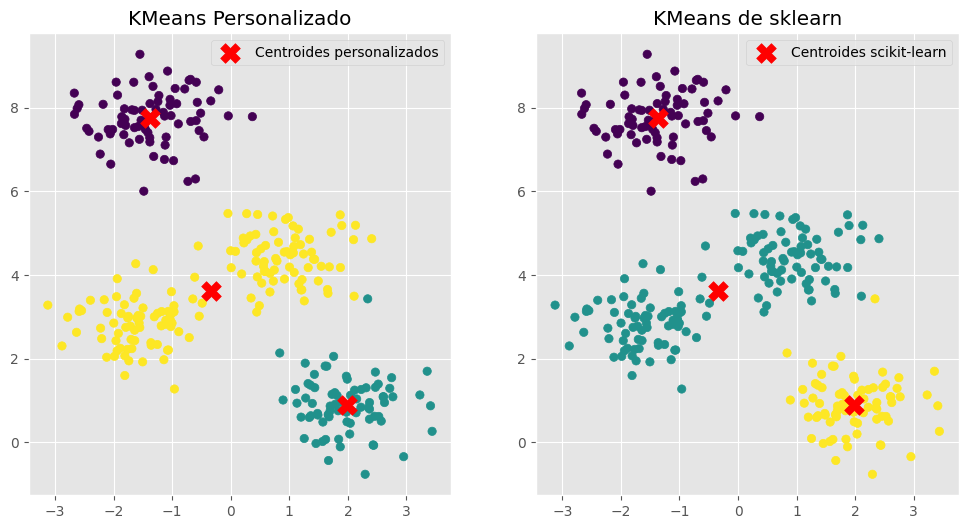

In [177]:
# Generar datos de prueba con make_blobs
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

# Inicializar y ajustar el modelo de KMeans personalizado
tiempoKmeans = time.time()
kmeans_custom = KMeansP(n_clusters=3)
kmeans_custom.fit(X)
labels_custom = kmeans_custom.predict(X)
centroids_custom = kmeans_custom.centroids
tiempo_ejecucion = time.time()-tiempoKmeans
print("Tiempo de ejecución de nuestro KMeans:", tiempo_ejecucion)

# Inicializar y ajustar el modelo de KMeans de scikit-learn
tiempoKmeans = time.time()
kmeans_sklearn = KMeans_sklearn(n_clusters=3)
kmeans_sklearn.fit(X)
labels_sklearn = kmeans_sklearn.predict(X)
centroids_sklearn = kmeans_sklearn.cluster_centers_
tiempo_ejecucion = time.time()-tiempoKmeans
print("Tiempo de ejecución de KMeans sklearn:", tiempo_ejecucion)
# Comparar los resultados
print("Centroides personalizados:\n", centroids_custom)
print("Centroides scikit-learn:\n", centroids_sklearn)

# Gráfico de los resultados
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis')
plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], marker='X', s=200, c='red', label='Centroides personalizados')
plt.title('KMeans Personalizado')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_sklearn, cmap='viridis')
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], marker='X', s=200, c='red', label='Centroides scikit-learn')
plt.title('KMeans de sklearn')
plt.legend()

#Mostrar gráficas
plt.show()

····················································································································································································································································
Nuestra implementación de sklearn proporciona las mismas divisiones de cluster que la implementación de Kmeans de sklearn, incluso nuestra implementación es más rápida esto puede ser debido a que sklearn utiliza más parámetros y es un modelo más complejo que necesita algo más de tiempo.
····················································································································································································································································

----------------------------------------------------------------------------------------------------------------
## CARGAR LOS DATOS 
----------------------------------------------------------------------------------------------------------------

In [178]:
# Cargar los datos del csv
import pandas as pd
# Archivo CSV a cargar
archivo = "Stars2.csv"
# Cargamos el archivo y lo mostramos por pantalla.
print(pd.read_csv(archivo))
data_set = pd.read_csv(archivo)  
#Mostrar por encima los datos del csv.
data_set.head()


     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12    Red              M
1           3042       0.000500     0.1542  16.60    Red              M
2           2600       0.000300     0.1020  18.70    Red              M
3           2800       0.000200     0.1600  16.65    Red              M
4           1939       0.000138     0.1030  20.06    Red              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93   Blue              O
236        30839  834042.000000  1194.0000 -10.63   Blue              O
237         8829  537493.000000  1423.0000 -10.73  White              A
238         9235  404940.000000  1112.0000 -11.23  White              A
239        37882  294903.000000  1783.0000  -7.80   Blue              O

[240 rows x 6 columns]


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


····················································································································································································································································
Vamos a comprobar que no hay ningún valor nulo y ver los tipos de los datos a anlizar.
····················································································································································································································································

In [179]:
print('The types of the attributes are:')
print('================================')
data_set.info()

print('How many missing values per attribute:')
print('======================================')
print(data_set.isnull().sum())

The types of the attributes are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB
How many missing values per attribute:
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64


····················································································································································································································································
Hemos comprobado que hay 4 atributos con valores numéricos y los otros dos son de tipo categórico. No hay ningún dato nulo en nuestro conjunto de datos. Tenemos los siguientes atributos:<br>
-Temperature: Temperatura promedio de la superficie en grados K.<br>
-L: Luminosidad comparada con la del Sol.<br>
-R: Radio comparado con la del Sol.<br>
-A_M: Magnitud absoluta (brillo aparente de la estrella si estuviera a 10 parsec de distancia).
-Color: Color principal del espectro. Los colores proporciona información sobre su temperatura superficial y, por lo tanto, sobre su luminosidad, tamaño y otras propiedades físicas. Estrellas más calientes suelen ser azulen y las más frías rojas.(Asoociado a la clase espectral(O---> SUELEN AZULES y M---> SUELEN ROJAS))<br>
-Spectral_Class: Clasificación espectral: es un valor que identifica la presencia elementos químicos en el espectro de la estrella. Es una secuencia (O, B, A, F, G, K, M) que se asocia a las estrellas desde las más calientes O, hasta las más frías M.<br>
····················································································································································································································································

----------------------------------------------------------------------------------------------------------------
## CODIFICACIÓN VARIABLES CATEGÓRICAS A ORDINALES
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Vamos a transformar los atributos categóricos a ordinales, para que se conserve el orden natural de las clases. Por ejemplo, en las clases espectrales O es el más caliente y M, es la más fría. Al asignar números a estas clases, mantendremos su orden de significado, con 0 representando el extremo más caliente, 1 el extremo más frío y valores intermedios reflejando el orden correspondiente entre las clases.No vamos a utilizar one-hot encoding para preservar el orden de las categorías.
····················································································································································································································································

····················································································································································································································································
Como en nuestro conjunto de datos hay mismos colores escritos de diferentes formas, vamos a modificarlo para que ese color aparezca igual en todas las instancias.
····················································································································································································································································

····················································································································································································································································
Realizamos la codificación ordinal de los colores. 0--->RED ... 11--->BLUE.
····················································································································································································································································

In [180]:
# Define el orden de los colores
corregido = pd.read_csv('Stars2.csv')
print("Dimensiones de corregido antes de la corrección del color:", corregido.shape)
color_order = ['Red', 'Orange-Red', 'Orange', 'Pale yellow orange', 'Yellowish', 
               'yellow-white', 'Whitish', 'Yellowish White', 'White-Yellow', 'White', 
               'Blue-white', 'Blue']

# Encuentra los valores únicos en la columna "Color".
unique_colors = set(corregido['Color'])

# Encuentra los valores de la columna "Color" que no están en color_order.
missing_colors = unique_colors - set(color_order)

# Imprime los valores que faltan
print("Valores de la columna Color que no están en color_order:")
for color in missing_colors:
    print(color)

# Define el diccionario de mapeo para corregir los valores incorrectos.
correction_mapping = {
    'Blue white': 'Blue-white',
    'Blue White': 'Blue-white',
    'Blue-White': 'Blue-white',
    'white': 'White',
    'yellowish': 'Yellowish'
}

# Reemplaza los valores incorrectos en la columna "Color".
corregido['Color'] = corregido['Color'].replace(correction_mapping)

corregido['Color'] = corregido['Color'].map(lambda x: color_order.index(x))
#Mostrar.
print(corregido)
print("Dimensiones de corregido después de la corrección del color:", corregido.shape)



Dimensiones de corregido antes de la corrección del color: (240, 6)
Valores de la columna Color que no están en color_order:
Blue White
white
Blue-White
yellowish
Blue white
     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12      0              M
1           3042       0.000500     0.1542  16.60      0              M
2           2600       0.000300     0.1020  18.70      0              M
3           2800       0.000200     0.1600  16.65      0              M
4           1939       0.000138     0.1030  20.06      0              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93     11              O
236        30839  834042.000000  1194.0000 -10.63     11              O
237         8829  537493.000000  1423.0000 -10.73      9              A
238         9235  404940.000000  1112.0000 -11.23      9              A
239        37882  294903.000000  1

····················································································································································································································································
Realizamos la codificación ordinal de la clase espectral. 0--->M ... 6--->O.
····················································································································································································································································

In [181]:
print("Dimensiones de corregido después de la corrección del color:", corregido.shape)

# Definir el orden de las clases espectrales.
spectral_class_order = ['M', 'K', 'G', 'F', 'A', 'B', 'O']

corregido['Spectral_Class'] = corregido['Spectral_Class'].map(lambda x: spectral_class_order.index(x))
# Muestrar el DataFrame con la columna 'Spectral_Class' reemplazada por los valores codificados.
print(corregido)


Dimensiones de corregido después de la corrección del color: (240, 6)
     Temperature              L          R    A_M  Color  Spectral_Class
0           3068       0.002400     0.1700  16.12      0               0
1           3042       0.000500     0.1542  16.60      0               0
2           2600       0.000300     0.1020  18.70      0               0
3           2800       0.000200     0.1600  16.65      0               0
4           1939       0.000138     0.1030  20.06      0               0
..           ...            ...        ...    ...    ...             ...
235        38940  374830.000000  1356.0000  -9.93     11               6
236        30839  834042.000000  1194.0000 -10.63     11               6
237         8829  537493.000000  1423.0000 -10.73      9               4
238         9235  404940.000000  1112.0000 -11.23      9               4
239        37882  294903.000000  1783.0000  -7.80     11               6

[240 rows x 6 columns]


----------------------------------------------------------------------------------------------------------------
## PCA
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Como hemos visto, para tener una visualización de las agrupaciones, tendríamos que reducir nuestro problema a dos o tres variables de entrada. Si es de dos entradas se podrá visualizar en dos dimensiones y si es en tres en tres dimensiones. Decidirimos que número de variables utilizar dependiendo de si la varianza es mayor a 0.8, en caso de que sea algo mejor la de tres variables que la de dos variables y sean ambas mayor que 0.8, nos quedaremos con las dos variables debido a que es más facil de interpretar.
····················································································································································································································································

In [182]:
# Escalado de las variables
# ==============================================================================
datos_scaled = scale(corregido, axis=0, with_mean=True, with_std=True)
datos_scaled_df = pd.DataFrame(datos_scaled, columns=corregido.columns, index=corregido.index)
datos_scaled_df.head(4)

,Temperature,L,R,A_M,Color,Spectral_Class
0,-0.779382,-0.598624,-0.459210,1.116745,-1.008818,-0.997781
1,-0.782110,-0.598624,-0.459241,1.162414,-1.008818,-0.997781
2,-0.828477,-0.598624,-0.459342,1.362213,-1.008818,-0.997781
3,-0.807496,-0.598624,-0.459229,1.167171,-1.008818,-0.997781


····················································································································································································································································
Crear una matriz de correlación para poder ver la correlación entre los atributos de entrada.En problemas en los que las variables de entrada estén muy correladas, podemos pensar en reducir el número de variables utilizando PCA.
····················································································································································································································································

<Axes: >

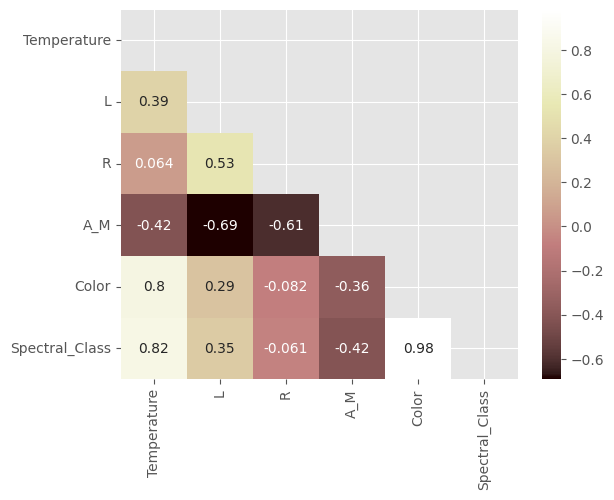

In [189]:

corr_df = corregido.corr()
etiquetas = corr_df.columns
mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)

# Crear el mapa de calor
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="pink")


·······················································································································································································································································
Con esta matriz de confusión podemos comprobar que las tres variables de entrada Spectral_class, temperature y color estan bastante correladas entre si con una correlación mayor o igual a 0.8(sobretodo spectral_class con color). También las otras variables A_M,L y R están algo correladas pero muchísimo menos que las anteriores al tener más de 0.6 de correlación(A_M con L y R).Por lo que existe una corelación significativa entre algunas de las variables.
·······················································································································································································································································

·······················································································································································································································································
## PCA DOS DIMENSIONES
·······················································································································································································································································

··························································································································································································································································
En este problema tenemos seis variables de entrada. Para poder graficarlo necesitamos convertirlo en un problema de dos o tres dimensiones. Primero, vamos a transformar los datos de entrada mediante PCA de dos dimensiones.
··························································································································································································································································

In [211]:
X = datos_scaled_df.values

# PCA con 2 componentes principales
pca = PCA(n_components=2)

# Ajustar y transformar los datos
X_trans = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
df_pca = pd.DataFrame(X_trans, columns=['PC1','PC2'])
df_pca.head()

,PC1,PC2,PC3
0,-2.067808,-0.147152,0.190962
1,-2.087328,-0.165090,0.195077
2,-2.188924,-0.236104,0.217676
3,-2.101169,-0.161525,0.198859
4,-2.273203,-0.273557,0.237536


In [212]:
std = df_pca.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.55409866 0.29691252 0.06395951]
Proporción acumulada: [0.55409866 0.85101118 0.91497069]


··························································································································································································································································
Como podemos observar, con dos variables, podemos contemplar el 85% de la varianza explicada del problema, lo que significa que las componentes PC1 y PC2, explican aproximadamente el 85% de la varianza total en los datos.
··························································································································································································································································

··························································································································································································································································
Vamos a graficar como se distribuyen las muestras en las nuevas coordenadas PC1 y PC2 
··························································································································································································································································

<Axes: xlabel='PC1', ylabel='PC2'>

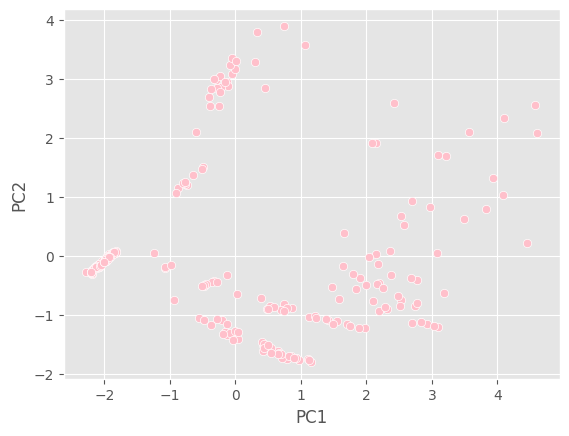

In [196]:
sns.scatterplot(data=df_pca, x="PC1", y="PC2", color='pink')

··························································································································································································································································
El gráfico biplot nos da información de cómo se ha realizado la transformación. Nos muestra unos vectores en los que se representan las variables de entrada. Cuanto más paralelo sea una variable al eje de una de las componente, mayor contribución ha aportada en la creación de esa componente. El ángulo también sirve para ver las correlaciones entre las variables y poder comparar a la correlación vista en la matriz. Un ángulo pequeño entre variables indica mayor correlación. Cuánto mayor sea la longitud de una variable mejor estará representada su información en el gráfico.
··························································································································································································································································

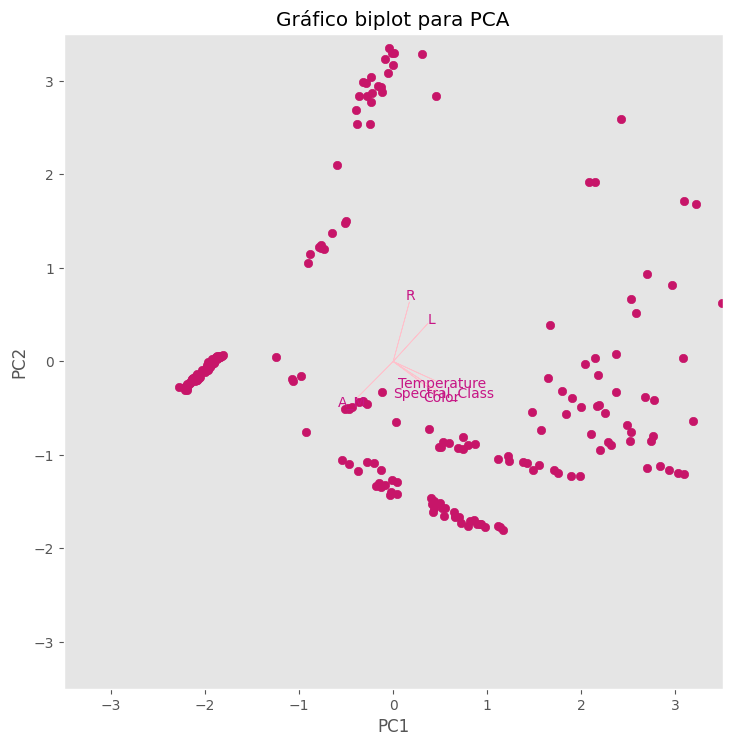

In [210]:
# Función para dibujar un gráfico biplot
# ==============================================================================

def biplot(scaled_data, fitted_pca, original_dim_labels):

    pca_results = fitted_pca.transform(scaled_data)
    pca1_scores = pca_results[:,0]
    pca2_scores = pca_results[:,1]

    # plot each point in 2D post-PCA space
    plt.scatter(pca1_scores,pca2_scores, color='#C71569')

    # label each point
    for i in range(len(pca1_scores)):
        plt.text(pca1_scores[i],pca2_scores[i], f'') 

    #for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0,i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1,i]
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2 ,color = 'pink',alpha = 1)
        plt.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, original_dim_labels[i], color = '#C71585', ha = 'center', va = 'center')




plt.figure(figsize=(8.5, 8.5))
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title("Gráfico biplot para PCA")
plt.grid()
biplot(datos_scaled, PCA().fit(datos_scaled), original_dim_labels=data_set.columns)


··························································································································································································································································
Como se puede observar en la gráfica, los ángulos de las variables de entrada Temperatura, Clase espectral y color forman ángulos muy pequeños entre sí. R y L contribuyen más a la creación de la componente PC2, y también se puede ver que su ángulo es pequeño,estando algo correladas entre sí.
··························································································································································································································································

----------------------------------------------------------------------------------------------------------------
## NÚMERO DE CLUSTERS
----------------------------------------------------------------------------------------------------------------

··························································································································································································································································
Cuanto mayor sea el valor de la puntuación, mejor será la estimación.
··························································································································································································································································

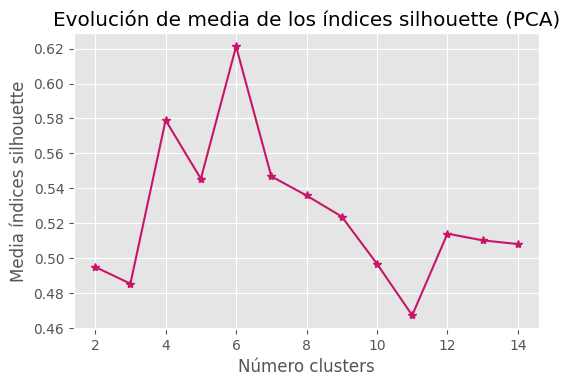

In [221]:

from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeansP(
        n_clusters=n_clusters
    )
    modelo_kmeans.fit(X=X_trans) 
    cluster_labels = modelo_kmeans.predict(X=X_trans)
    silhouette_avg = silhouette_score(X_trans, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Plot
plt.figure(figsize=(6, 3.84))
plt.plot(range_n_clusters, valores_medios_silhouette, marker='*', color='#C71569')
plt.title("Evolución de media de los índices silhouette (PCA)")
plt.xlabel('Número clusters')
plt.ylabel('Media índices silhouette')
plt.show()


··························································································································································································································································
Como se puede ver el mejor valor de cluster es 6, por lo que n_clusters, de ahora en adelantes será de seis.
··························································································································································································································································

----------------------------------------------------------------------------------------------------------------
## APLICACIÓN DE DIFERENTES ALGORITMOS DE CLUSTERING
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Para nuestros datos vamos a utilizar el algoritmo de KMEANS personalizado.Es importante conocer antes de aplicar este algoritmo el número de clusters(grupos), anteriormente calculado. Para comenzar, vamos a implementar nuestro algoritmo con K fijado a 4 para compararlo posteriormente con el de seis, que ha sido el indicado en los índices silhoutte.
····················································································································································································································································

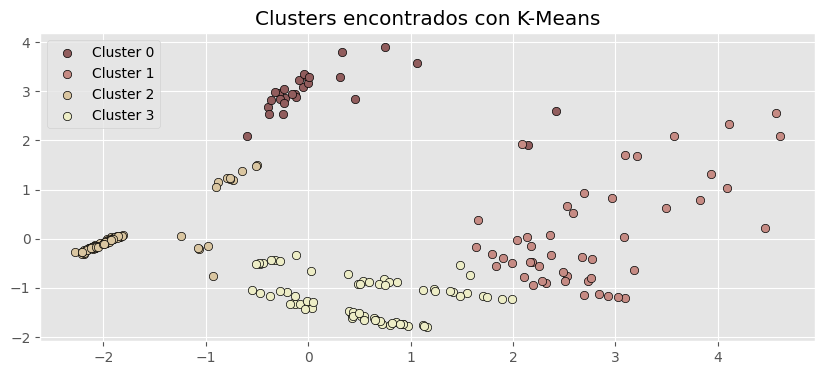

In [224]:
# Definir una paleta de colores personalizada en tonos de rosa
custom_palette = sns.color_palette("pink", 4)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, figsize=(10, 4))

# Clustering con tu KMeans personalizado
modelo_kmeans = KMeansP(n_clusters=4).fit(X=X_trans)
y_predict_Kmeans = modelo_kmeans.predict(X=X_trans)

for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        x=X_trans[y_predict_Kmeans == i, 0],
        y=X_trans[y_predict_Kmeans == i, 1],
        c=custom_palette[i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )
ax.set_title('Clusters encontrados con K-Means')
ax.legend()

plt.show()


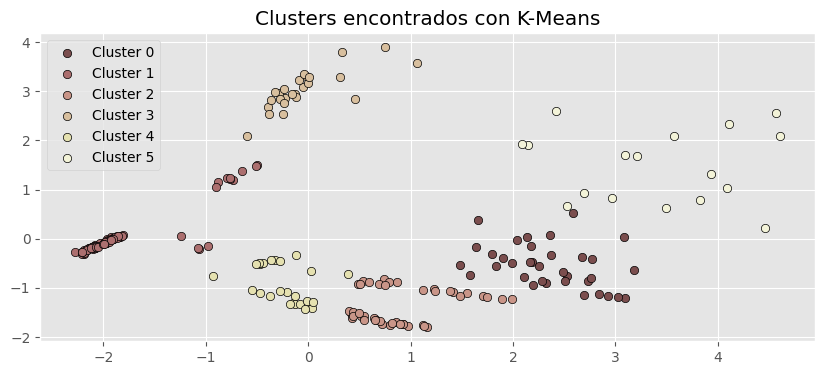

In [225]:
# Definir una paleta de colores personalizada en tonos de rosa
custom_palette = sns.color_palette("pink", 6)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, figsize=(10, 4))

# Clustering con tu KMeans personalizado
modelo_kmeans = KMeansP(n_clusters=6).fit(X=X_trans)
y_predict_Kmeans = modelo_kmeans.predict(X=X_trans)

for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        x=X_trans[y_predict_Kmeans == i, 0],
        y=X_trans[y_predict_Kmeans == i, 1],
        c=custom_palette[i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )
ax.set_title('Clusters encontrados con K-Means')
ax.legend()

plt.show()
